# Notebook Setup

In [1]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    # MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/TFT_baseline"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    # MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"
    MY_HOME_ABS_PATH = "/home/ec2-user/SageMaker/co2-flux-hourly-gpp-modeling"

## Import Modules

In [2]:
import os
os.chdir(MY_HOME_ABS_PATH)

import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters, MetricsCallback
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

import optuna
from optuna.integration import PyTorchLightningPruningCallback, TensorBoardCallback

# from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle


# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib_for_nbinstance import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

2023-04-15 10:44:59.373483: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-15 10:44:59.425123: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 10:45:00.157637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Global seed set to 42
Global seed set to 42


42

In [3]:
# data/models/tft_model_1yrtrain_tuning_230318_1906/trial_0/epoch=12.ckpt

## Define Local File System Constants

In [4]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
raw_data_dir = tmp_dir
data_dir = root_dir + os.sep + 'data'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'
model_objects_dir = root_dir + os.sep + 'code/src/modeling/model_objects'

# Load Train and Test dataset from Azure Storage Blob

In [5]:
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"

local_file = tmp_dir + os.sep + blob_name

In [6]:
# def get_raw_datasets(container, blob_name):
local_file = tmp_dir + os.sep + blob_name
data_df = None
if not (os.path.exists(local_file)):
    azStorageClient = AzStorageClient(az_cred_file)
    file_stream = azStorageClient.downloadBlob2Stream(container, blob_name)
    data_df = pd.read_parquet(file_stream, engine='pyarrow')
    data_df.to_parquet(local_file)
else:
    data_df = pd.read_parquet(local_file)

print(f"Data size: {data_df.shape}")

# Convert Dtypes
cat_cols = ["year", "month", "day", "hour", "MODIS_IGBP", "koppen_main", "koppen_sub", 
            "gap_flag_month", "gap_flag_hour"]
for col in cat_cols:
    data_df[col] = data_df[col].astype(str).astype("category")

print(f"Data Columns: {data_df.columns}")
print(f"NA count: {data_df.isna().sum().sum()}")
# return data_df

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


# Load Best NO 16 noGPP TFT As of April 14

In [13]:
# best_model_path_GPP = f"{MY_HOME_ABS_PATH}/data/models/GPPTFT_5yrTrain_2WkEncode_230410_2310/lightning_logs/version_1/checkpoints/epoch=9-step=74795.ckpt"
best_model_path_GPP = f"{MY_HOME_ABS_PATH}/data/models/tft_model_16_tft_nogpp_7D_small_lr_230406_0405/lightning_logs/version_0/checkpoints/epoch=8-step=360882.ckpt"


In [15]:
best_noGPP = TemporalFusionTransformer.load_from_checkpoint(best_model_path_GPP)
print(f"Quantiles: {best_noGPP.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]


# Make prediction for three best models

In [26]:
# Experiment constants
VAL_INDEX  = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365*5
ENCODER_LEN = 24*7   # 7 days
print(f"Training timestemp length = {SUBSET_LEN}.")

# Create dataloaders for model
batch_size = 64
cpu_count = os.cpu_count()

Training timestemp length = 43800.


## Create TS Dataset

In [27]:
# Setup dataset
train_df, val_df, test_df = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, test_df = subset_data(train_df, val_df, test_df, SUBSET_LEN)

Subest length: 43800 timesteps for each sites
Subset num train timesteps: 2579424
Subset num val timesteps: 952752
Subset num test timesteps: 891744


In [28]:
site_list = val_df["site_id"].unique()

In [29]:
val_df[['site_id','MODIS_IGBP']].drop_duplicates().reset_index(drop=True)

,site_id,MODIS_IGBP
0,AU-DaP,GRA
1,AU-Emr,GRA
2,AU-Gin,SAV
3,AU-How,SAV
4,AU-Rig,GRA
5,CA-Ca1,ENF
6,CA-Gro,MF
7,CH-Fru,MF
8,CH-Oe2,CRO
9,DE-Hai,DBF


In [21]:
# AU-DaP	GrassLand GRA
# NL-Loo	SAV	SAV Savanna
# US-Ses	OSH Open Shrublands
# CA-Gro	MF Mixed Forest
# US-Bar	DBF 
# FI-Hyy	ENF Evergreen Needleleaf Forest
# FR_Aur	CRO Cropland

# Convert to TS dataset

In [40]:
min_encoder_len = ENCODER_LEN

training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'BESS-RSDN',],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

# Define function

In [32]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [37]:
def pred_raw_noGPP(val_dataloader):
    print(f"Start eval on validation.")
    start = default_timer()
    val_raw_pred, val_x = best_noGPP.predict(val_dataloader, show_progress_bar=True,
                                                   mode="raw", return_x=True)
    eval_time = default_timer() - start
    print(f"Val eval time: {eval_time}")
    return  val_raw_pred, val_x

In [38]:
def raw_pred_x_to_dict(model_name, val_or_test, site_name, val_raw_pred, val_x):
    
    
    # Store raw_predictions
    # Create dictionary
    val_raw_pred_dict = {}
    for i in val_raw_pred.keys():
        val_raw_pred_dict[i] = val_raw_pred[i]
    val_raw_pred_dict.keys()
    
    with open(f'{val_or_test}_raw_pred_{site_name}_{model_name}.pkl', 'wb') as handle:
        pickle.dump(val_raw_pred_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # open pickle from storage
    with open(f'{val_or_test}_raw_pred_{site_name}_{model_name}.pkl', 'rb') as handle:
        val_raw_pred_site = pickle.load(handle)
 
    # Store x
    val_x_dict = {}
    for i in val_x.keys():
        val_x_dict[i] = val_x[i]
    val_x_dict.keys()
    
    with open(f'{val_or_test}_x_pred_{site_name}_{model_name}.pkl', 'wb') as handle:
        pickle.dump(val_x_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # open pickle from storage
    with open(f'{val_or_test}_x_pred_{site_name}_{model_name}.pkl', 'rb') as handle:
        val_x_site = pickle.load(handle)
                                                       
    return val_raw_pred_site, val_x_site


Define the functions that do prediction end-to-end

In [39]:
def site_raw_pred(model_name, site_name, val_or_test, df, training):
    # filter with site id
    df_site = df[df["site_id"] == site_name]
    print(f'filtered with {site_name}')
    
    # create TS dataset
    df_site_ts = TimeSeriesDataSet.from_dataset(training,
                                                df_site,
                                                predict=False, stop_randomization=True)
    print(f'TS dataset created')
    # create dataloader
    site_dataloader = df_site_ts.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)
    print(f'dataloader created')
    
    # obtain raw prediction and x
    raw_pred, x = pred_raw(site_dataloader)
    print(f'prediction completed')
    
    # convert to dict and save to pkl
    print(f'saving to pickle')
    raw_pred_dict, x_dict = raw_pred_x_to_dict(model_name, val_or_test, site_name, raw_pred, x)
    
    print(f'deleting used files')
    del df_site, df_site_ts, site_dataloader, raw_pred, x

    return raw_pred_dict, x_dict
    

# Run Prediction

In [41]:
model_name = "tft_model_16_tft_nogpp_7D_small_lr_230406_0405"
site_name = "AU-DaP"

raw_AU_DaP, x_AU_DaP = site_raw_pred(model_name, site_name, "val", val_df, training)

filtered with AU-DaP
TS dataset created
dataloader created
Start eval on validation.


Predict: 100%|██████████| 503/503 [00:21<00:00, 23.78 batches/s]


Val eval time: 21.156669135999437
prediction completed
saving to pickle
deleting used files


In [ ]:
# AU-DaP	GrassLand GRA
# US-AR1	GrassLand GRA
# US-Bar	DBF 
# FI-Hyy	ENF Evergreen Needleleaf Forest
# FR_Aur	CRO Cropland

In [42]:
model_name = "tft_model_16_tft_nogpp_7D_small_lr_230406_0405"
site_name = "FI-Hyy"

raw_FI_Hyy, x_FI_Hyy = site_raw_pred(model_name, site_name, "val", val_df, training)

filtered with FI-Hyy
TS dataset created
dataloader created
Start eval on validation.


Predict: 100%|██████████| 682/682 [00:27<00:00, 24.96 batches/s]


Val eval time: 27.325335377000556
prediction completed
saving to pickle
deleting used files


In [43]:
model_name = "tft_model_16_tft_nogpp_7D_small_lr_230406_0405"
site_name = "US-Bar"

raw_US_Bar, x_US_Bar = site_raw_pred(model_name, site_name, "val", val_df, training)

filtered with US-Bar
TS dataset created
dataloader created
Start eval on validation.


Predict: 100%|██████████| 682/682 [00:28<00:00, 23.97 batches/s]


Val eval time: 28.46050572599961
prediction completed
saving to pickle
deleting used files


In [44]:
model_name = "tft_model_16_tft_nogpp_7D_small_lr_230406_0405"
site_name = "FR-Aur"

raw_FR_Aur, x_FR_Aur = site_raw_pred(model_name, site_name, "val", val_df, training)

filtered with FR-Aur
TS dataset created
dataloader created
Start eval on validation.


Predict: 100%|██████████| 682/682 [00:29<00:00, 23.32 batches/s]


Val eval time: 29.255138438999893
prediction completed
saving to pickle
deleting used files


## Try predction with data

In [25]:
test_df[['site_id','MODIS_IGBP']].drop_duplicates().reset_index(drop=True)

,site_id,MODIS_IGBP
0,AU-Stp,GRA
1,AU-Whr,GRA
2,CA-Oas,DBF
3,CH-Dav,WSA
4,CZ-Lnz,DBF
5,CZ-wet,WET
6,DE-Gri,ENF
7,DE-Lnf,CRO
8,DE-Tha,CRO
9,ES-Amo,OSH


# Interpretation

In [46]:
print(f'encoder variables: {best_noGPP.encoder_variables}')
encoder_var = best_noGPP.encoder_variables
len(best_noGPP.encoder_variables)

encoder variables: ['month', 'hour', 'gap_flag_month', 'gap_flag_hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'BESS-RSDN', 'relative_time_idx']


15

## Function1 Create df of feature importance of the snapshot t

In [53]:
datetime_list = [[2010,8,1,0],[2010,8,1,12],[2011,1,1,0],[2011,1,1,12]]

In [66]:
def snapshot_stack_TFT_fi(site_name, df, TRAIN_LEN, ENCODER_LEN, # df is val_df or test_df
                          raw_pred, x,
                          year, month, day, hour):
    
    print(f'Site_Name: {site_name}')
    print(f'Train Size: {int(TRAIN_LEN)}, Encoder Length {ENCODER_LEN}')
    print(f'Year/ Date/ Hour of the prediction time t: {year}-{month}-{day} {hour}(hour)')

    # Search the global index for the desireable datetime
    global_time_idx = df[df["site_id"] == site_name][df["year"]== str(year) ][df["month"]== str(month)][df["day"]== str(day)][df["hour"]== str(hour)]['timestep_idx_global'].reset_index(drop=True)[0]
    print(f'global_time_idx: {global_time_idx}')

    # Find which index in raw prediction and x
    for idx, time_idx in enumerate(x["decoder_time_idx"]):
        if time_idx == global_time_idx:
            raw_x_index = idx
            print(idx)
            break

    # tensor to list
    encoder_fi = []
    for i in raw_pred['encoder_variables'][raw_x_index]:
        encoder_fi += [list(i.numpy()[0])]

    # column name(feature name) and order
    tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path_GPP)
    encoder_var = tft.encoder_variables
    print(f'encoder_variables: {encoder_var}')

    # Define encoder index -1 to -168( or -336)
    encoder_fi_df = pd.DataFrame(encoder_fi, columns=encoder_var)
    encoder_index = [-(ENCODER_LEN -i) for i in range(ENCODER_LEN)]
    encoder_index#.reverse()

    # Add encoer index
    encoder_fi_df["encoder_index"] = encoder_index
    
    # encoder_index comes first column
    columns_order = list(encoder_fi_df.columns[-1:]) + list(encoder_fi_df.columns[:-1])
    encoder_size_fi_df  = encoder_fi_df[columns_order]
    
    # add encoder attention to df 
    encoder_size_fi_df["encoder_attention"] = list(raw_pred["encoder_attention"][idx][0][0].numpy())

    
    return encoder_size_fi_df

## Function2 Stack Area Plot and Attention

In [106]:
def stack_attention_plot(site_name, encoder_fi_df, feature_list, ENCODER_LEN, topX, datehour): 
    '''
    Function that creates plot with attention.
    Feature can be either assigned or selected from top features
    in "topX", provide integer between 5-10.
    If feature_list is blank, automatically choose topX(choose from 5-15)
    datehour need to be provided with format [year, month, day, hour] and each components should be string
    '''
    
    import seaborn as sns
    #set seaborn style
    sns.set_theme()
    pal = sns.color_palette("crest")
    sns.set(rc={'figure.figsize':(30,7), })

    if feature_list == []:
        encoder_fi_rank_df = pd.DataFrame(encoder_fi_df.sum()/ENCODER_LEN, columns=['avg_encoder_imp'])
        encoder_fi_rank_df = encoder_fi_rank_df.sort_values(by=['avg_encoder_imp'], ascending=False)
        topX_features = list(encoder_fi_rank_df[:topX].index)
        print(f'{topX} features')
        print(topX_features)
        feature_list = topX_features

    #create area chart
    if topX == 5:    
        plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]], encoder_fi_df[feature_list[2]],
                      encoder_fi_df[feature_list[3]],encoder_fi_df[feature_list[4]],
                      labels=feature_list, colors=pal)
    if topX == 6:
        plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]], encoder_fi_df[feature_list[2]],
                      encoder_fi_df[feature_list[3]],encoder_fi_df[feature_list[4]],encoder_fi_df[feature_list[5]],
                      labels=feature_list, colors=pal)
    if topX == 7:
        plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]],encoder_fi_df[feature_list[2]],
                      encoder_fi_df[feature_list[3]],encoder_fi_df[feature_list[4]],encoder_fi_df[feature_list[5]],
                      encoder_fi_df[feature_list[6]],
                      labels=feature_list, colors=pal)
    if topX == 8:
        plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]],encoder_fi_df[feature_list[2]],encoder_fi_df[feature_list[3]],
                      encoder_fi_df[feature_list[4]],encoder_fi_df[feature_list[5]],encoder_fi_df[feature_list[6]],encoder_fi_df[feature_list[7]],
                      labels=feature_list, colors=pal)

    if topX == 9:
        plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]],encoder_fi_df[feature_list[2]],
                      encoder_fi_df[feature_list[3]],encoder_fi_df[feature_list[4]],encoder_fi_df[feature_list[5]],
                      encoder_fi_df[feature_list[6]],encoder_fi_df[feature_list[7]],encoder_fi_df[feature_list[8]],
                      labels=feature_list, colors=pal)

    if topX == 10:
         plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]],encoder_fi_df[feature_list[2]],encoder_fi_df[feature_list[3]],
                      encoder_fi_df[feature_list[4]],encoder_fi_df[feature_list[5]],encoder_fi_df[feature_list[6]],encoder_fi_df[feature_list[7]],
                      encoder_fi_df[feature_list[8]],encoder_fi_df[feature_list[9]],
                      labels=feature_list, colors=pal)
            
    if topX == 11:
         plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]],encoder_fi_df[feature_list[2]],encoder_fi_df[feature_list[3]],
                      encoder_fi_df[feature_list[4]],encoder_fi_df[feature_list[5]],encoder_fi_df[feature_list[6]],encoder_fi_df[feature_list[7]],
                      encoder_fi_df[feature_list[8]],encoder_fi_df[feature_list[9]],encoder_fi_df[feature_list[10]],
                      labels=feature_list, colors=pal)
    if topX == 12:
         plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]],encoder_fi_df[feature_list[2]],encoder_fi_df[feature_list[3]],
                      encoder_fi_df[feature_list[4]],encoder_fi_df[feature_list[5]],encoder_fi_df[feature_list[6]],encoder_fi_df[feature_list[7]],
                      encoder_fi_df[feature_list[8]],encoder_fi_df[feature_list[9]],encoder_fi_df[feature_list[10]],encoder_fi_df[feature_list[11]],
                      labels=feature_list, colors=pal)
    if topX == 13:
         plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]],encoder_fi_df[feature_list[2]],encoder_fi_df[feature_list[3]],
                      encoder_fi_df[feature_list[4]],encoder_fi_df[feature_list[5]],encoder_fi_df[feature_list[6]],encoder_fi_df[feature_list[7]],
                      encoder_fi_df[feature_list[8]],encoder_fi_df[feature_list[9]],encoder_fi_df[feature_list[10]],encoder_fi_df[feature_list[11]],
                      encoder_fi_df[feature_list[12]],
                       labels=feature_list,colors=pal)
    if topX == 14:
         plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]],encoder_fi_df[feature_list[2]],encoder_fi_df[feature_list[3]],
                      encoder_fi_df[feature_list[4]],encoder_fi_df[feature_list[5]],encoder_fi_df[feature_list[6]],encoder_fi_df[feature_list[7]],
                      encoder_fi_df[feature_list[8]],encoder_fi_df[feature_list[9]],encoder_fi_df[feature_list[10]],encoder_fi_df[feature_list[11]],
                      encoder_fi_df[feature_list[12]],encoder_fi_df[feature_list[13]],
                      labels=feature_list, colors=pal)
    
    if topX == 15:
         plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]],encoder_fi_df[feature_list[2]],encoder_fi_df[feature_list[3]],
                      encoder_fi_df[feature_list[4]],encoder_fi_df[feature_list[5]],encoder_fi_df[feature_list[6]],encoder_fi_df[feature_list[7]],
                      encoder_fi_df[feature_list[8]],encoder_fi_df[feature_list[9]],encoder_fi_df[feature_list[10]],encoder_fi_df[feature_list[11]],
                      encoder_fi_df[feature_list[12]],encoder_fi_df[feature_list[13]],encoder_fi_df[feature_list[14]],
                      labels=feature_list, colors=pal)

    # Reverse the order of labels in legend
    plt.legend(reversed(plt.legend().legendHandles), reversed(feature_list), loc='upper left', fontsize=14)

    #add axis labels
    plt.title(f'{site_name} Feature Importance by Encoder Length / Average Attention', fontsize=20)
    plt.ylabel('Importance (All Features Total 1.0)', fontsize=18)
    plt.xlabel(f'Encoder Relative Index (1hour before pred ~ {ENCODER_LEN}(24*{int(ENCODER_LEN/24)}) hours before pred)', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14) # fontsize of both axes

    plt2 = plt.twinx()

    plt2.plot(encoder_fi_df["encoder_index"], encoder_fi_df["encoder_attention"], color='pink', linewidth=5)
    plt2.set_ylabel('Average Attention', fontsize=18)
    plt2.tick_params('y', colors='k')
    plt.show()
    plt.savefig(f'fi_attention_GPP_TFT_{ENCODER_LEN}_{site_name}_{datehour[0]}-{datehour[1]}-{datehour[2]}-{datehour[3]}.png')

In [82]:
# print(site_name)
# df = val_df
# print(TRAIN_LEN)
# print(ENCODER_LEN)
# raw_pred = raw_FR_Aur
# x = x_FR_Aur

In [83]:
# encoder_fi_FR_Aur =  snapshot_stack_TFT_fi(site_name, df, TRAIN_LEN, ENCODER_LEN, # df is val_df or test_df
#                       raw_pred, x,
#                       year, month, day, hour)
# encoder_fi_FR_Aur.head()

## Create plot

### AU-DaP

In [84]:
datetime_list

[[2010, 8, 1, 0], [2010, 8, 1, 12], [2011, 1, 1, 0], [2011, 1, 1, 12]]

In [85]:
site_name = "AU-DaP" # bar instead of under bar
df = val_df
TRAIN_LEN = SUBSET_LEN/365/24
print(ENCODER_LEN)
raw_pred = raw_AU_DaP# raw_FR_Aur,
x =  x_AU_DaP #x_FR_Aur
year = 2010
month = 1
day = 8
hour = 0
datehour = ["2010","1","8","0"]

168


In [86]:
global_time_idx = df[df["site_id"] == site_name][df["year"]== str(year) ][df["month"]== str(month)][df["day"]== str(day)][df["hour"]== str(hour)]['timestep_idx_global'].reset_index(drop=True)[0]
print(f'global_time_idx: {global_time_idx}')

global_time_idx: 350808


In [87]:
x['decoder_time_idx']

tensor([[350808],
        [350809],
        [350810],
        ...,
        [382941],
        [382942],
        [382943]])

In [74]:
encoder_fi_df_AU_DaP = snapshot_stack_TFT_fi(site_name, df, TRAIN_LEN, ENCODER_LEN, # df is val_df or test_df
                                              raw_pred, x,
                                              year, month, day, hour)

Site_Name: AU-DaP
Train Size: 5, Encoder Length 168
Year/ Date/ Hour of the prediction time t: 2010-1-8 0(hour)
global_time_idx: 350808
0
encoder_variables: ['month', 'hour', 'gap_flag_month', 'gap_flag_hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'BESS-RSDN', 'relative_time_idx']


15 features
['gap_flag_hour', 'NDVI', 'SW_IN_ERA', 'relative_time_idx', 'VPD_ERA', 'BESS-RSDN', 'gap_flag_month', 'PA_ERA', 'LW_IN_ERA', 'hour', 'NIRv', 'TA_ERA', 'month', 'EVI', 'P_ERA']


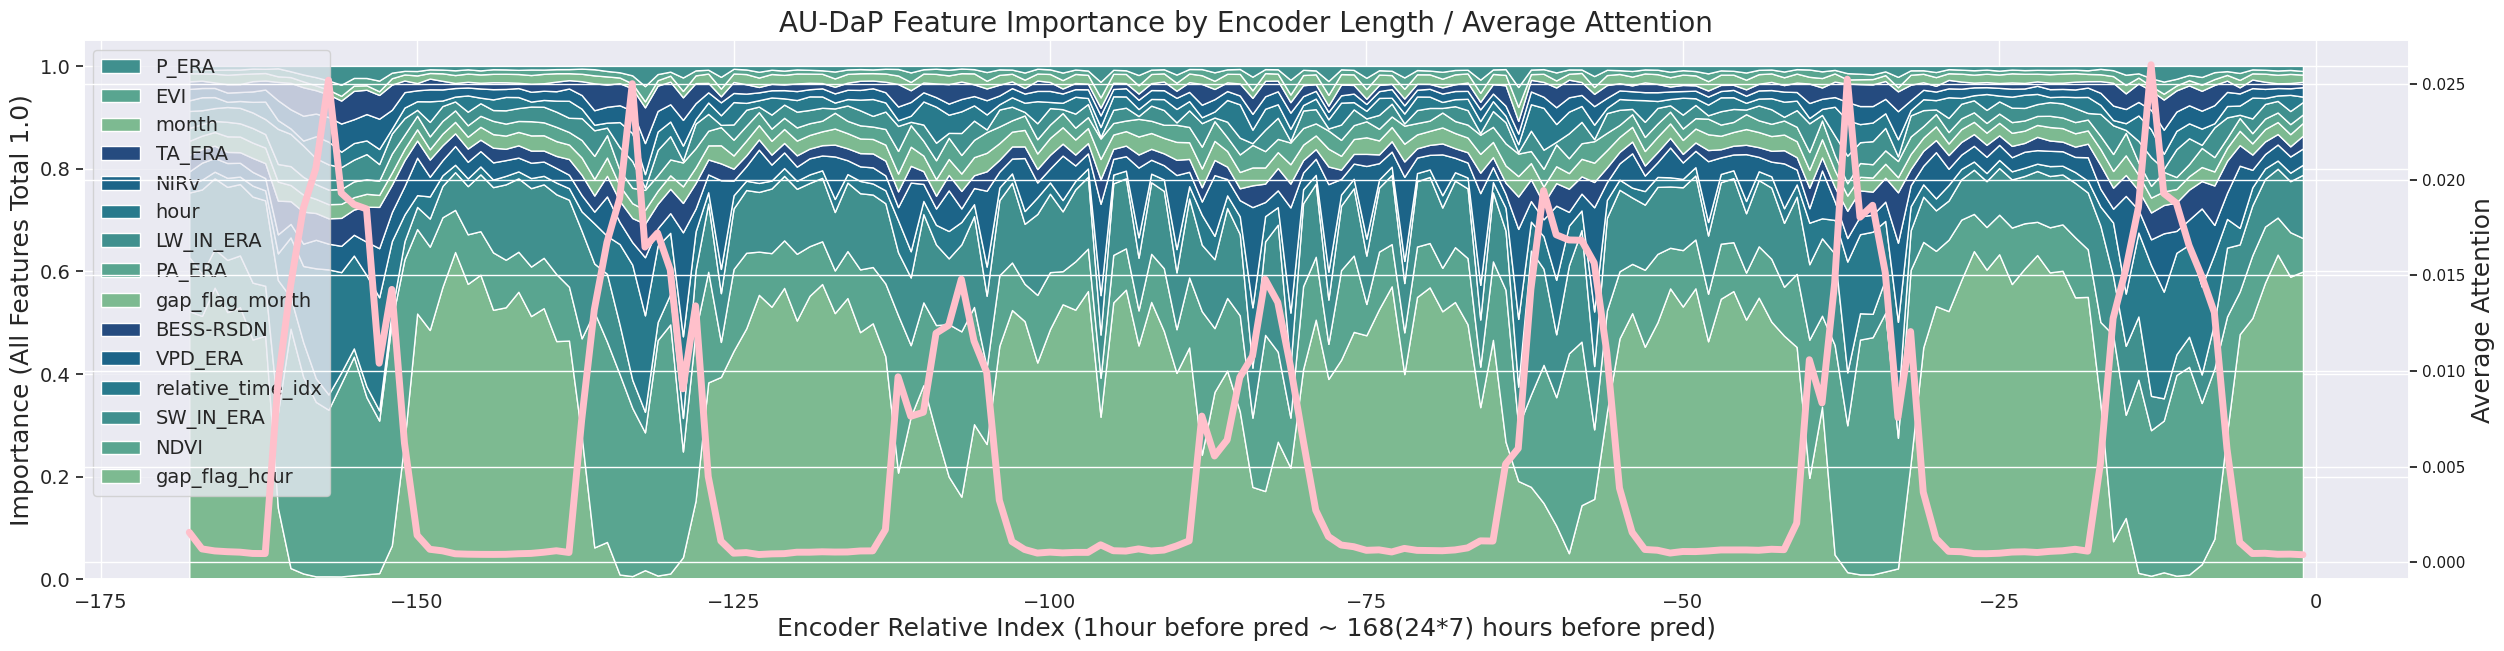

<Figure size 3000x700 with 0 Axes>

In [88]:
stack_attention_plot(site_name, encoder_fi_df_AU_DaP, feature_list, ENCODER_LEN, 15, datehour)

In [80]:
encoder_fi_df = encoder_fi_df_AU_DaP 
if feature_list == []:
    encoder_fi_df = pd.DataFrame(encoder_fi_df.sum()/ENCODER_LEN, columns=['avg_encoder_imp'])
    encoder_fi_df = encoder_fi_df.sort_values(by=['avg_encoder_imp'], ascending=False)
    topX_features = list(encoder_fi_df.index)
topX_features

['gap_flag_hour',
 'NDVI',
 'SW_IN_ERA',
 'relative_time_idx',
 'VPD_ERA',
 'BESS-RSDN',
 'gap_flag_month',
 'PA_ERA',
 'LW_IN_ERA',
 'hour',
 'NIRv',
 'TA_ERA',
 'month',
 'EVI',
 'P_ERA',
 'encoder_attention',
 'encoder_index']

#### AU Dap has gap in 5-9 AM

In [104]:
val_df_AU_Dap = val_df[val_df["site_id"] == "AU-DaP"]
val_df_AU_Dap.groupby(by =['gap_flag_month','gap_flag_hour','hour']).count()

GPP_NT_VUT_REF  site_id  \
gap_flag_month gap_flag_hour hour                            
0.0            0.0           0               1054     1054   
                             1               1054     1054   
                             10              1054     1054   
                             11              1054     1054   
                             12              1054     1054   
...                                           ...      ...   
1.0            1.0           5                161      161   
                             6                161      161   
                             7                161      161   
                             8                161      161   
                             9                161      161   

                                   timestep_idx_local  timestep_idx_global  \
gap_flag_month gap_flag_hour hour                                            
0.0            0.0           0                   1054                 1054   
                             1                   1054                 1054   
                             10                  1054                 1054   
                             11                  1054                 1054   
                             12                  1054                 1054   
...                                               ...                  ...   
1.0            1.0           5                    161                  161   
                             6                    161                  161   
                             7                    161                  161   
                             8                    161                  161   
                             9                    161                  161   

                                   datetime  date  year  month   day  TA_ERA  \
gap_flag_month gap_flag_hour hour                                              
0.0            0.0           0         1054  1054  1054   1054  1054    1054   
                             1         1054  1054  1054   1054  1054    1054   
                             10        1054  1054  1054   1054  1054    1054   
                             11        1054  1054  1054   1054  1054    1054   
                             12        1054  1054  1054   1054  1054    1054   
...                                     ...   ...   ...    ...   ...     ...   
1.0            1.0           5          161   161   161    161   161     161   
                             6          161   161   161    161   161     161   
                             7          161   161   161    161   161     161   
                             8          161   161   161    161   161     161   
                             9          161   161   161    161   161     161   

                                   SW_IN_ERA  LW_IN_ERA  VPD_ERA  P_ERA  \
gap_flag_month gap_flag_hour hour                                         
0.0            0.0           0          1054       1054     1054   1054   
                             1          1054       1054     1054   1054   
                             10         1054       1054     1054   1054   
                             11         1054       1054     1054   1054   
                             12         1054       1054     1054   1054   
...                                      ...        ...      ...    ...   
1.0            1.0           5           161        161      161    161   
                             6           161        161      161    161   
                             7           161        161      161    161   
                             8           161        161      161    161   
                             9           161        161      161    161   

                                   PA_ERA   EVI  NDVI  NIRv    b1    b2    b3  \
gap_flag_month gap_flag_hour hour                                               
0.0            0.0           0    

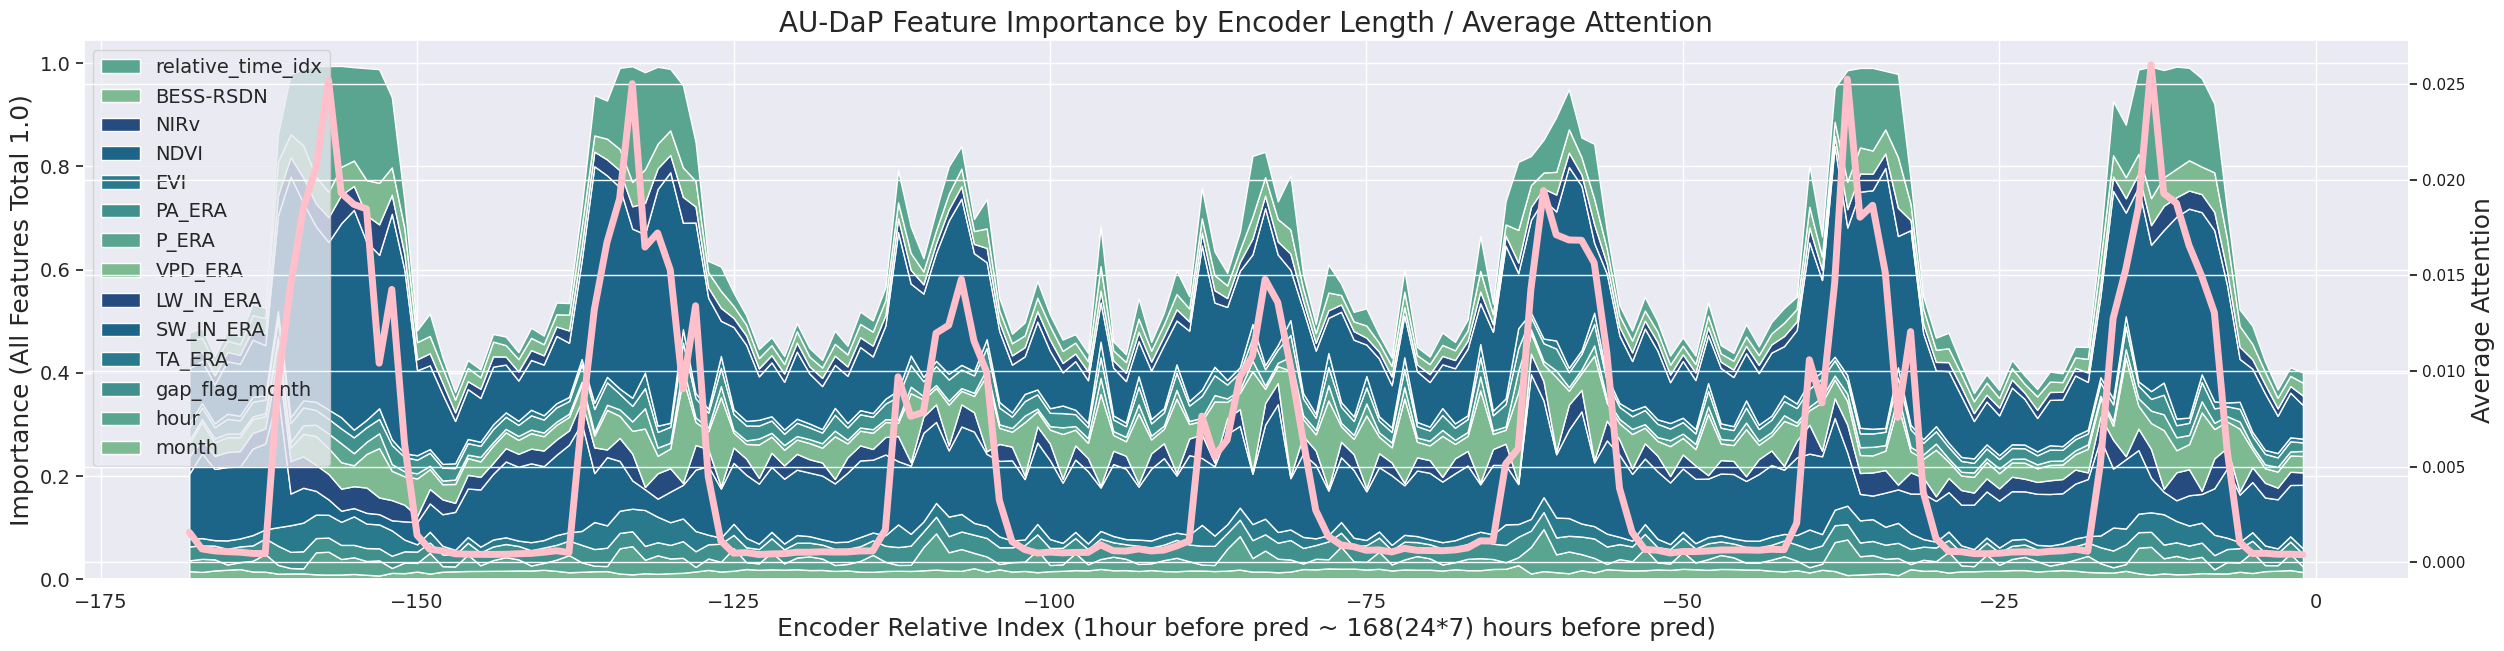

<Figure size 3000x700 with 0 Axes>

In [107]:
feature_list = ['month', 'hour', 'gap_flag_month', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'BESS-RSDN', 'relative_time_idx']
# 'gap_flag_hour', 
stack_attention_plot(site_name, encoder_fi_df_AU_DaP, feature_list, ENCODER_LEN, len(feature_list), datehour)


In [7]:
datetime_list

NameError: name 'datetime_list' is not defined

### 